In [1]:
%gui qt
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.spatial.distance import euclidean
from skimage import measure
from src.methods.aorta_contour import morphological_ACWE_evolution
from src.define.path import uncontrast, contrast
from src.data.io import read_serie, show_image
from src.process.range import window_image
from src.process.contour import scale, center, area, max_width
from src.process.cluster import pseudo_dbscan_1d

In [2]:
path = "data/03_Burov/DICOM/ST00001/SE00001"
image, space = read_serie(path, step=4)
print(path)

data/03_Burov/DICOM/ST00001/SE00001


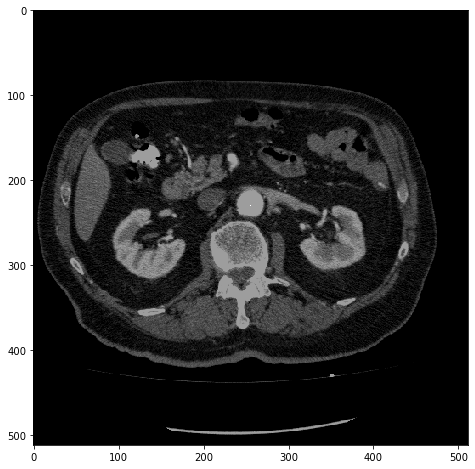

In [3]:
point = (300, 230, 256)
slice_ = window_image(image[point[0]].copy(), 50, 200)
slice_[point[1], point[2]] = 500

plt.figure(figsize=(8,8))
plt.imshow(slice_, cmap='gray')

In [8]:
def aorta(image, point):
    binary = image > 150

    labeled = measure.label(binary, connectivity=1)
    label = labeled[point[0], point[1]]
    binary = labeled == label

    return binary

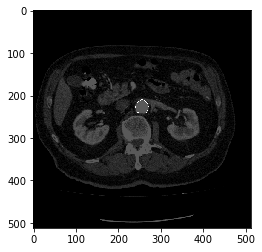

In [10]:
labeled = aorta(slice_, point[1:3])
contours, _ = cv2.findContours(labeled.astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
aorta_contour = contours[0]
canvas = slice_.copy()
cv2.drawContours(canvas, contours, -1, 1000, 1)
plt.imshow(canvas, cmap='gray')

In [15]:
point1 = 328, 220, 250
point2 = 369, 220, 250

In [19]:
image.shape

(618, 512, 512)

In [16]:
def analyze_aorta(image, space, point1, point2):
    segment = np.zeros_like(image, dtype='bool')
    height = (point2[0] - point1[0]) * space[2]
    start_height = point1[0]
    volume = 0
    cent = point1[1:3]
    labels = aorta(image[start_height], cent)
    segment[start_height] = labels
    contours, _ = cv2.findContours(labels.astype('uint8'), cv2.RETR_TREE, 1)
    contour = contours[0]
    contour = contour.astype('float32')
    cent = center(contour)
    contour = scale(contour, space[:2])
    width = max_width(contour)
    prev_area = area(contour)

    for i in range(1, point2[0] - point1[0] + 1):
        labels = aorta(image[start_height+i], cent)
        if i == 0:
            plt.imshow(labels)
        segment[start_height+i] = labels
        contours, _ = cv2.findContours(labels.astype('uint8'), cv2.RETR_TREE, 1)
        contour = contours[0].astype('float32')
        cent = center(contour)
        contour = scale(contour, space[:2])
        w = max_width(contour)
        width = width if width > w else w
        a = area(contour)
        max_area = a if a > prev_area else prev_area
        min_area = a if a < prev_area else prev_area
        volume += ((3*max_area + min_area) / 4) * space[2]
        prev_area = a

    return width, height, volume, segment.astype('int8')


width, height, volume, segment = analyze_aorta(image, space, point1, point2)

IndexError: tuple index out of range

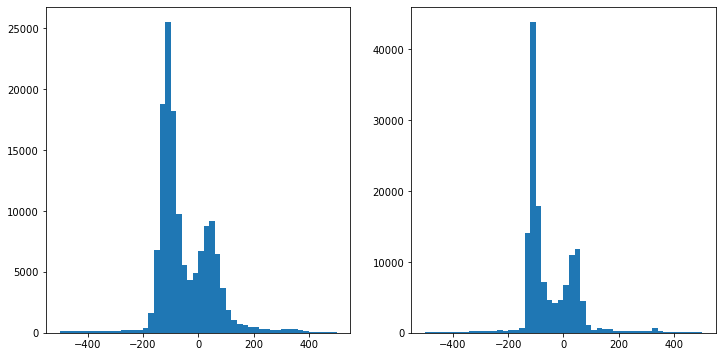

In [16]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(imgg.flatten(), bins=50, range=(-500, 500))
axes[1].hist(filtered.flatten(), bins=50, range=(-500, 500))
plt.show()